This data analysis will help us to predict the job title of a new employee based on salary, physical presence obligation (remote or not), experience level, and company size.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('ds_salaries.csv')
data.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


First I will perform the following to clean and sharpen my data:
 - Filter the data such that it only shows US based employees
 - Remove columns that will not be helpful
 - Limit the data to job titles that only have 50 or more entries
 - Convert remote ratio to boolean and remove the small amount of entries that do not fit the boolean
 - Change experience and company size to one-hot encoded values

In [2]:
#filter for only US data
data = data[data['salary_currency'] == 'USD']

#drop unnecessary columns
cols = ['salary', 'remote_ratio', 'experience_level', 'company_size', 'job_title']
data = data[cols]

#limit to only certain job titles (ones with at least 50 data points)
job_title_counts = data['job_title'].value_counts()
selected_job_titles = job_title_counts[job_title_counts >= 50].index.tolist()
data = data[data['job_title'].isin(selected_job_titles)]

# Simplify remote ratio to boolean by removing half remote jobs
condition1 = data['remote_ratio'] == 0
condition2 = data['remote_ratio'] == 100
final_condition = condition1 | condition2
data = data[final_condition]

# Convert remote_ratio to boolean
Yes = data['remote_ratio'] == 100
No = data['remote_ratio'] == 0
data.loc[Yes, 'remote_ratio'] = 1
data.loc[No, 'remote_ratio'] = 0

# Convert experience_level to one-hot encoded columns with 1s and 0s
one_hot = pd.get_dummies(data['experience_level'], dtype=int)
data = data.drop('experience_level', axis=1)
data = data.join(one_hot)

# Convert company_size to one-hot encoded columns with 1s and 0s
one_hot = pd.get_dummies(data['company_size'], dtype=int)
data = data.drop('company_size', axis=1)
data = data.join(one_hot)

# Move job_title column to the end
job_title = data.pop('job_title')
data['job_title'] = job_title

data.head()

,salary,remote_ratio,EN,EX,MI,SE,L,M,S,job_title
3,175000,1,0,0,0,1,0,1,0,Data Scientist
4,120000,1,0,0,0,1,0,1,0,Data Scientist
5,222200,0,0,0,0,1,1,0,0,Applied Scientist
6,136000,0,0,0,0,1,1,0,0,Applied Scientist
7,219000,0,0,0,0,1,0,1,0,Data Scientist


This is the final data that I am going to use for this analysis. 


In [3]:
data.shape

(2757, 10)

There are 2757 instances in the dataset.

In [4]:
data.dtypes

salary           int64
remote_ratio     int64
EN               int32
EX               int32
MI               int32
SE               int32
L                int32
M                int32
S                int32
job_title       object
dtype: object

There are 5 features in the dataset, four with an int64 data type and one with an object type.

Significance of features:
- "salary" shows how much each employee is compensated in a year which can help us indicate what role the employee holds in the company
- "remote_ratio" shows whether or not the employee is a remote worker which might help show us what their role could be based upon their physical presence obligation
- "EN", "EX", "MI", and "SE" are one-hot encoded columns that show the experience level of each employee which can help us determine the role the employee has in the company because some roles tend to require more experience than others
- "S", "M", and "L" are one-hot encoded columns that show the size of the company which can help us indicate what role the employee will likely have since the availability of roles varies by size of the company
- "job_title" tells us what the employees title/role in the company is which will be what we will try to predict

What the values look like:
- "salary" -> 175000 (in USD)
- "remote_ratio" -> 1 (meaning remote worker) or 0 (meaning in person worker)
- "EN", "EX", "MI", and "SE" -> 1 (indicating the employee has that experience level) or 0 (indicating the employee does not have that experience level)
- "S", "M", and "L" -> 1 (indicating the company is that size) or 0 (indicating the company is not that size)
- "job_title" -> A title ex. "Principal Data Scientist"

It would be interesting to predict the Job Title of an employee based on the other features.

In [5]:
data.groupby('job_title').size().sort_values(ascending=False)

job_title
Data Engineer                923
Data Scientist               689
Data Analyst                 538
Machine Learning Engineer    235
Data Architect               101
Analytics Engineer            95
Research Scientist            63
Applied Scientist             58
Data Science Manager          55
dtype: int64

The distribution is unbalanced. I could cut the values so that there is 50 of each job. Therefore the amount of jobs would be the same.

In [6]:
data = data.groupby('job_title').apply(lambda x: x.sample(55) if x['job_title'].iloc[0] in selected_job_titles else None).reset_index(drop=True)
data.shape

(495, 10)

In [7]:
# Group by experience level
grouped = data.groupby(['EN', 'EX', 'MI', 'SE']).size().reset_index(name='count')

print(grouped)

   EN  EX  MI  SE  count
0   0   0   0   1    380
1   0   0   1   0     69
2   0   1   0   0     14
3   1   0   0   0     32


In [8]:
# Group by experience level
grouped = data.groupby(['S', 'M', 'L']).size().reset_index(name='count')
print(grouped)

   S  M  L  count
0  0  0  1     57
1  0  1  0    432
2  1  0  0      6


In [9]:
data.groupby('remote_ratio').size().sort_values(ascending=False)

remote_ratio
0    255
1    240
dtype: int64

There are no features with zero variance thus there is none to remove. None of the features of the dataset are fully balanced although the remote_ratio is close to even.
The task is not solvable without machine learning. Given the features from this data, it is not possible to predict the job title of an employee. The features are not strong enough to predict the job title of an employee without the use of machine learning. This would be an unsupervised learning problem.

In [10]:
data.describe()

,salary,remote_ratio,EN,EX,MI,SE,L,M,S
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000
mean,163757.949495,0.484848,0.064646,0.028283,0.139394,0.767677,0.115152,0.872727,0.012121
std,61629.360458,0.500276,0.246150,0.165947,0.346708,0.422741,0.319528,0.333615,0.109538
min,10000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,125000.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
50%,159100.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
75%,200000.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,450000.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


These are the descriptive statistics above.



Now I will look through the distribution of the different features and visualize the data to try to find insights to help us understand the data better:

<Axes: title={'center': 'Job Title Counts'}, xlabel='Job Title', ylabel='Count'>

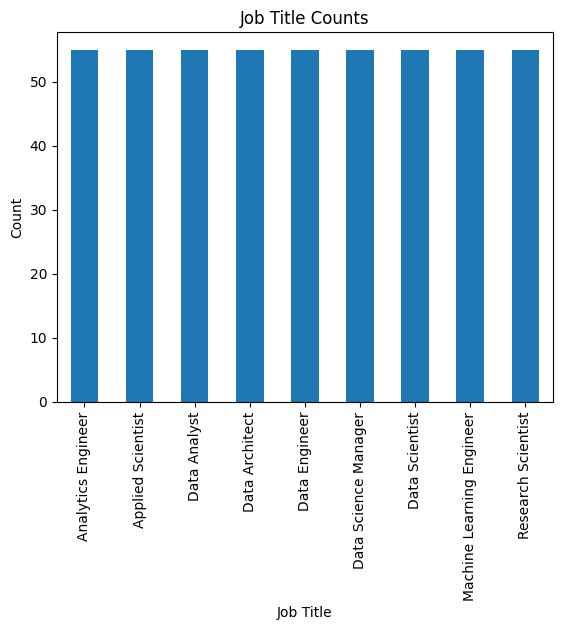

In [11]:
data['job_title'].value_counts().plot(kind='bar', xlabel='Job Title', ylabel='Count', title='Job Title Counts')

This shows us the distribution and counts of the data points grouped by the Job Title category that we are going to seek to predict with this analysis. First thing to note is that the majority of the jobs fall under data engineer, data scientist, or data analyst.

<Axes: title={'center': 'Experience Level Counts'}, xlabel='Experience Level', ylabel='Count'>

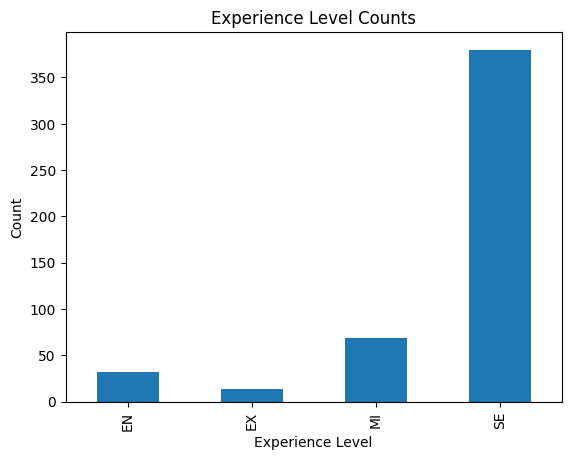

In [12]:
# Plot counts of experience levels
data[['EN', 'EX', 'MI', 'SE']].sum().plot(kind='bar', xlabel='Experience Level', ylabel='Count', title='Experience Level Counts')

This shows us the distribution of experience levels which at first glance shows us that the vast majority of the positions in the data are senior level positions.

<Axes: title={'center': 'Company Size Counts'}, xlabel='Company Size', ylabel='Count'>

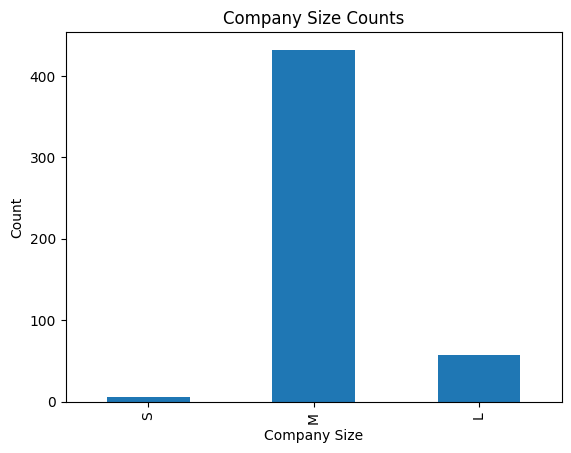

In [13]:
# Plot counts of company sizes
data[['S', 'M', 'L']].sum().plot(kind='bar', xlabel='Company Size', ylabel='Count', title='Company Size Counts')

This shows us the distribution of company sizes which at first glance shows us that the vast majority of the positions in the data are for medium size conpanies.

<Axes: title={'center': 'Remote Counts'}, xlabel='Remote', ylabel='Count'>

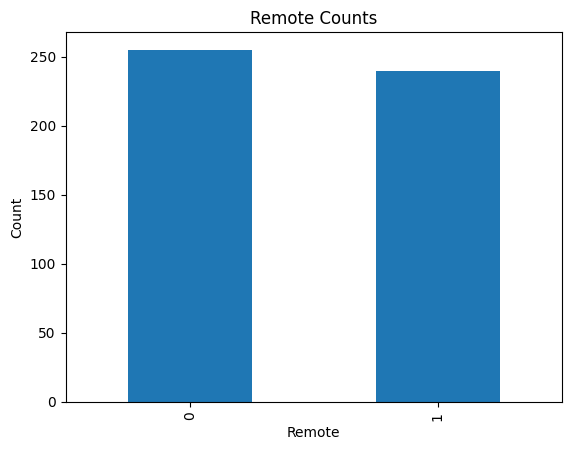

In [14]:
data['remote_ratio'].value_counts().plot(kind='bar', xlabel='Remote', ylabel='Count', title='Remote Counts')

This shows us the distribution of the remote and in person positions. Note that the remote and in person positions seem to be fairly similar in instance count.

Next I will show the distribution of Salary by Job Title using both a Joint Plot and Box Plots:

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Analytics Engineer'),
  Text(1, 0, 'Applied Scientist'),
  Text(2, 0, 'Data Analyst'),
  Text(3, 0, 'Data Architect'),
  Text(4, 0, 'Data Engineer'),
  Text(5, 0, 'Data Science Manager'),
  Text(6, 0, 'Data Scientist'),
  Text(7, 0, 'Machine Learning Engineer'),
  Text(8, 0, 'Research Scientist')])

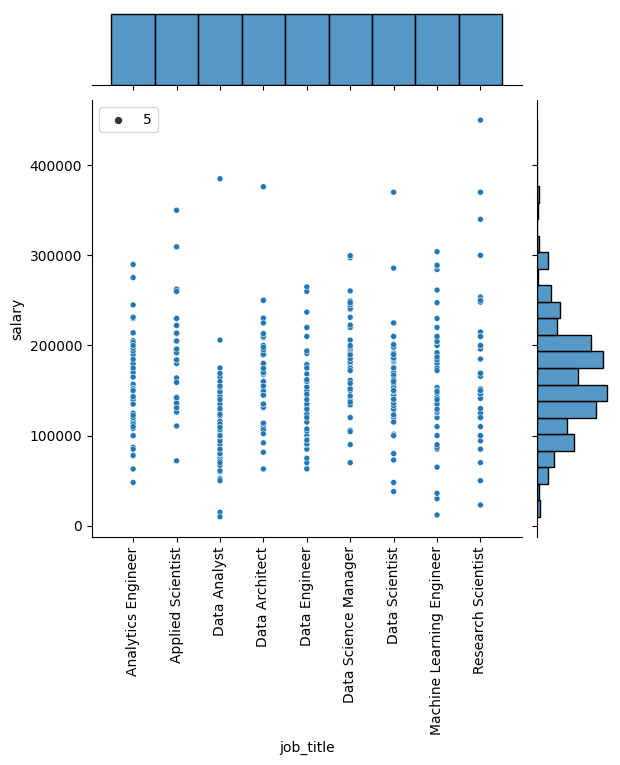

In [15]:
sns.jointplot(x="job_title", y="salary", data=data, size=5)

#Rotate x-axis labels
plt.xticks(rotation=90)

This joint plot shows us how the salaries are heavily concentrated within $100,000 and $200,000 range and that data engineer and data scientist appear the most in the data set.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Analytics Engineer'),
  Text(1, 0, 'Applied Scientist'),
  Text(2, 0, 'Data Analyst'),
  Text(3, 0, 'Data Architect'),
  Text(4, 0, 'Data Engineer'),
  Text(5, 0, 'Data Science Manager'),
  Text(6, 0, 'Data Scientist'),
  Text(7, 0, 'Machine Learning Engineer'),
  Text(8, 0, 'Research Scientist')])

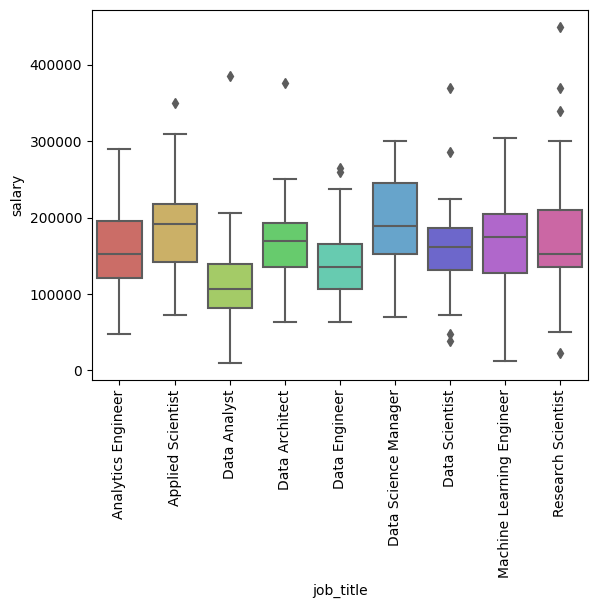

In [16]:
sns.boxplot(x="job_title", y="salary", palette="hls", data=data)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

These box plots indicate that the salaries do not have a great deal of variation with respect to Job Title. This is surprising considering salary is perceived to be a known indicator of one's role in a company.

Next we will look at how experience level, company size, and remote obligation are distributed by each job title:

Text(0.5, 0, 'Job Title')

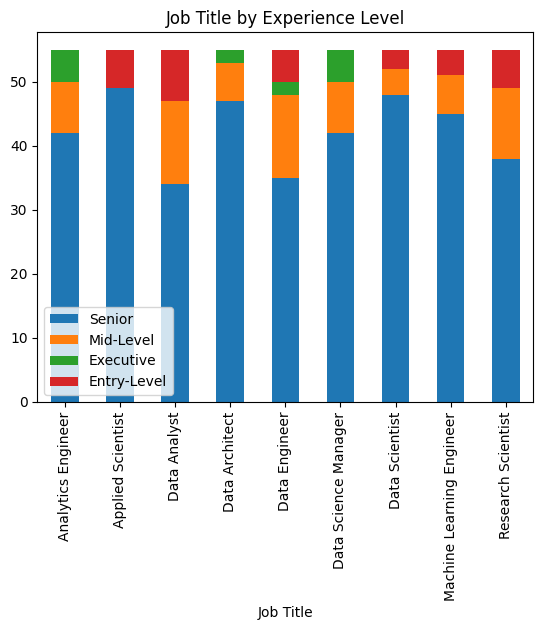

In [17]:
pd.crosstab(data['job_title'], [data['EN'], data['EX'], data['MI'], data['SE']]).plot(kind='bar', stacked=True)
plt.legend(labels=['Senior', 'Mid-Level', 'Executive', 'Entry-Level'])
plt.title('Job Title by Experience Level')
plt.xlabel('Job Title')

This stacked bar graph is very insightful as we can see that although all of the positions reflect a majority make-up of senior level positions, there are some positions such as Analytics Engineer, Data Architect, Data Science Manager, and Research Scientist that have less portion of Midlevel positions, while some positions like Research Scientist, Data Science Manager, and Applied Scientist tend to have a smaller portion of  entry level positions. This may prove to be helpful in differentiating and predicting different Job Titles.

Text(0.5, 0, 'Job Title')

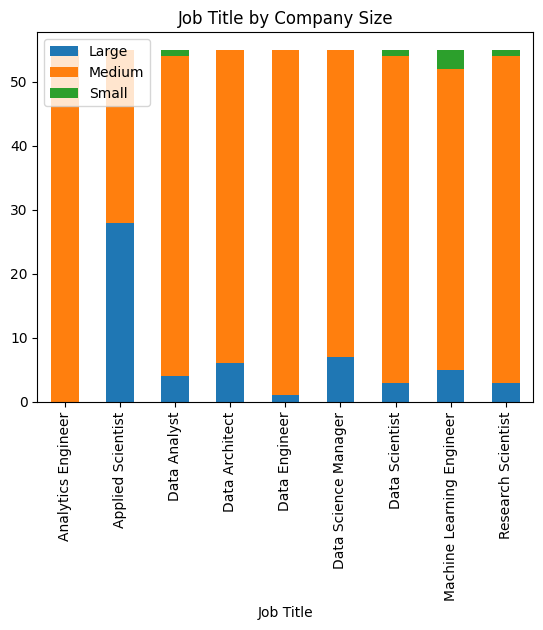

In [18]:
pd.crosstab(data['job_title'], [data['S'], data['M'], data['L']]).plot(kind='bar', stacked=True)
plt.legend(labels=['Large', 'Medium', 'Small'])
plt.title('Job Title by Company Size')
plt.xlabel('Job Title')

This stacked bar graph is also very insightful as we can see that some positions are more prevalent in large companies than others. This could also prove to be helpful in predicting a Job Title.

Text(0.5, 0, 'Job Title')

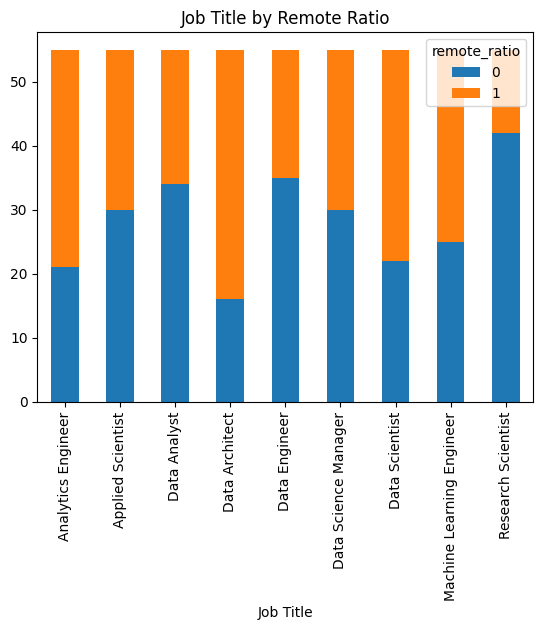

In [19]:
pd.crosstab(data['job_title'], data['remote_ratio']).plot(kind='bar', stacked=True)
plt.title('Job Title by Remote Ratio')
plt.xlabel('Job Title')

This stacked bar graph is very insightful for reasons similar to the previous two. This bar graph shows us how some job titles have a smaller portion of in person workers than others, and vice-versa.

<Axes: xlabel='EN-EX-MI-SE', ylabel='job_title'>

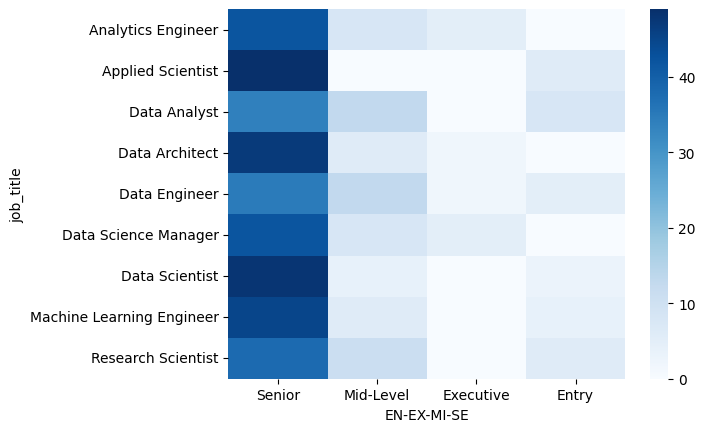

In [20]:
# Group the filtered dataset
df_grouped = data.groupby(['job_title', 'EN', 'EX', 'MI', 'SE']).size().reset_index(name='count')

# Reshape the grouped dataset
df_reshaped = df_grouped.pivot_table(index='job_title', columns=['EN', 'EX', 'MI', 'SE'], values='count', fill_value=0)

# Create a heatmap
sns.heatmap(df_reshaped, cmap='Blues', annot=False, fmt='g', xticklabels=['Senior', 'Mid-Level', 'Executive', 'Entry'])

<Axes: xlabel='S-M-L', ylabel='job_title'>

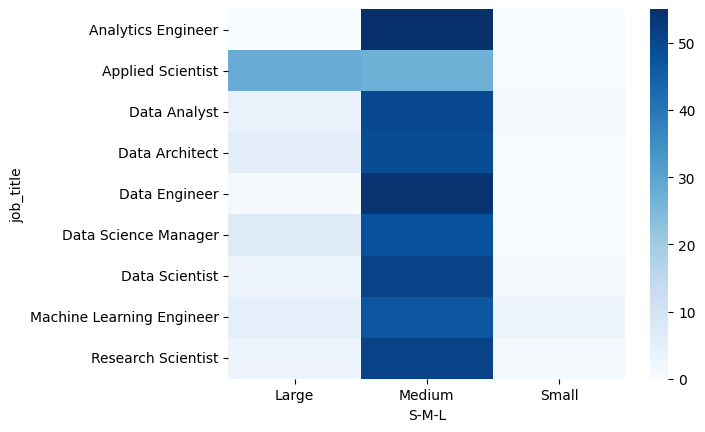

In [21]:
# Filter the dataset
df_filtered = data[['job_title', 'EN', 'EX', 'MI', 'SE', 'S', 'M', 'L']]

# Group the filtered dataset
df_grouped = df_filtered.groupby(['job_title', 'S', 'M', 'L']).size().reset_index(name='count')

# Reshape the grouped dataset
df_reshaped = df_grouped.pivot_table(index='job_title', columns=['S', 'M', 'L'], values='count', fill_value=0)

# Create a heatmap
sns.heatmap(df_reshaped, cmap='Blues', annot=False, fmt='g', xticklabels=['Large', 'Medium', 'Small'])

Next I will use a FacetGrid to show the density of salary distribution by job title:

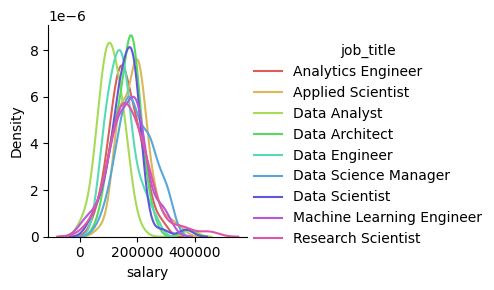

In [22]:
# Create the FacetGrid with the filtered data
g = sns.FacetGrid(data, hue="job_title", palette="hls")

# Map the kdeplot onto the FacetGrid
g.map(sns.kdeplot, "salary", shade=False)

# Add a legend
g.add_legend()

Observe that the data analyst position is much more dense at the area of $150,000 salary, while the applied scientist is more dense around the $200,000 salary. Also observe that the research scientist and data science manager positions are spread more evenly than the other positions but peak around the $175,000-$200,000 range.

Next I will standardize and normalize the data:

In [23]:
# Standardize the data
from sklearn.preprocessing import StandardScaler

# Save job_title column before scaling
job_title = data.pop('job_title')


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
data.head()

,salary,remote_ratio,EN,EX,MI,SE,L,M,S
0,245000,0,0,0,0,1,0,1,0
1,153000,1,0,1,0,0,0,1,0
2,138750,1,0,0,0,1,0,1,0
3,179820,0,0,0,0,1,0,1,0
4,157000,1,0,1,0,0,0,1,0


In [24]:
print("Mean: ", data_scaled.mean(axis=0))
print("Stdev: ", data_scaled.std(axis=0))
print("Min: ", data_scaled.min(axis=0))
print("Max: ", data_scaled.max(axis=0))

Mean:  [ 1.72252784e-16 -2.87087974e-17 -3.58859968e-17 -2.69144976e-17
  2.15315981e-17  1.84812883e-16 -4.30631961e-17  5.74175948e-17
 -1.43543987e-17]
Stdev:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Min:  [-2.49740538 -0.9701425  -0.26289631 -0.17060489 -0.40245724 -1.81778652
 -0.36074504 -2.61861468 -0.11076976]
Max:  [4.6492714  1.03077641 3.80378101 5.86149664 2.48473601 0.5501196
 2.77204086 0.38188131 9.02773504]


We see here that the values are manipulated such that the value of the Stdev is made to be one.

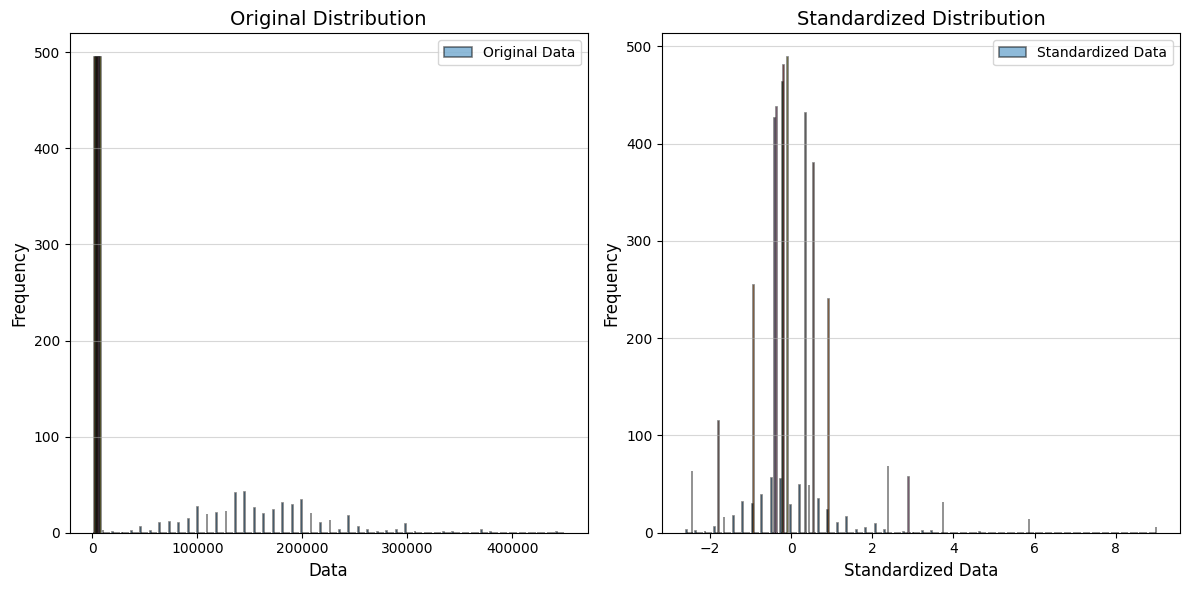

In [25]:
# Create histograms for both original and standardized data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data, bins=50, alpha=0.5, label='Original Data', edgecolor='black', linewidth=1.2)
plt.title('Original Distribution', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.subplot(1, 2, 2)
plt.hist(data_scaled, bins=50, alpha=0.5, label='Standardized Data', edgecolor='black', linewidth=1.2)
plt.title('Standardized Distribution', fontsize=14)
plt.xlabel('Standardized Data', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.5)

plt.tight_layout()

In [26]:
# # Convert back to DataFrame and add job_title column
import numpy as np
data_scaled = np.column_stack((data_scaled, job_title))
data_scaled = pd.DataFrame(data_scaled, columns=data.columns.tolist() + ['job_title'])

data_scaled.head()

,salary,remote_ratio,EN,EX,MI,SE,L,M,S,job_title
0,1.31957,-0.970143,-0.262896,-0.170605,-0.402457,0.55012,-0.360745,0.381881,-0.11077,Analytics Engineer
1,-0.174735,1.030776,-0.262896,5.861497,-0.402457,-1.817787,-0.360745,0.381881,-0.11077,Analytics Engineer
2,-0.40619,1.030776,-0.262896,-0.170605,-0.402457,0.55012,-0.360745,0.381881,-0.11077,Analytics Engineer
3,0.260887,-0.970143,-0.262896,-0.170605,-0.402457,0.55012,-0.360745,0.381881,-0.11077,Analytics Engineer
4,-0.109766,1.030776,-0.262896,5.861497,-0.402457,-1.817787,-0.360745,0.381881,-0.11077,Analytics Engineer


It seems that the standardization of the data did yield a considerable shift in the distribution of the existing data.

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(data)

In [28]:
print("Mean: ", data_norm.mean(axis=0))
print("Stdev: ", data_norm.std(axis=0))
print("Min: ", data_norm.min(axis=0))
print("Max: ", data_norm.max(axis=0))

Mean:  [0.34944989 0.48484848 0.06464646 0.02828283 0.13939394 0.76767677
 0.11515152 0.87272727 0.01212121]
Stdev:  [0.13992518 0.49977038 0.24590099 0.1657797  0.34635714 0.42231404
 0.31920471 0.33327823 0.10942709]
Min:  [0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]


We see here that all of the values in the entirety of the data are confined between zero and one.

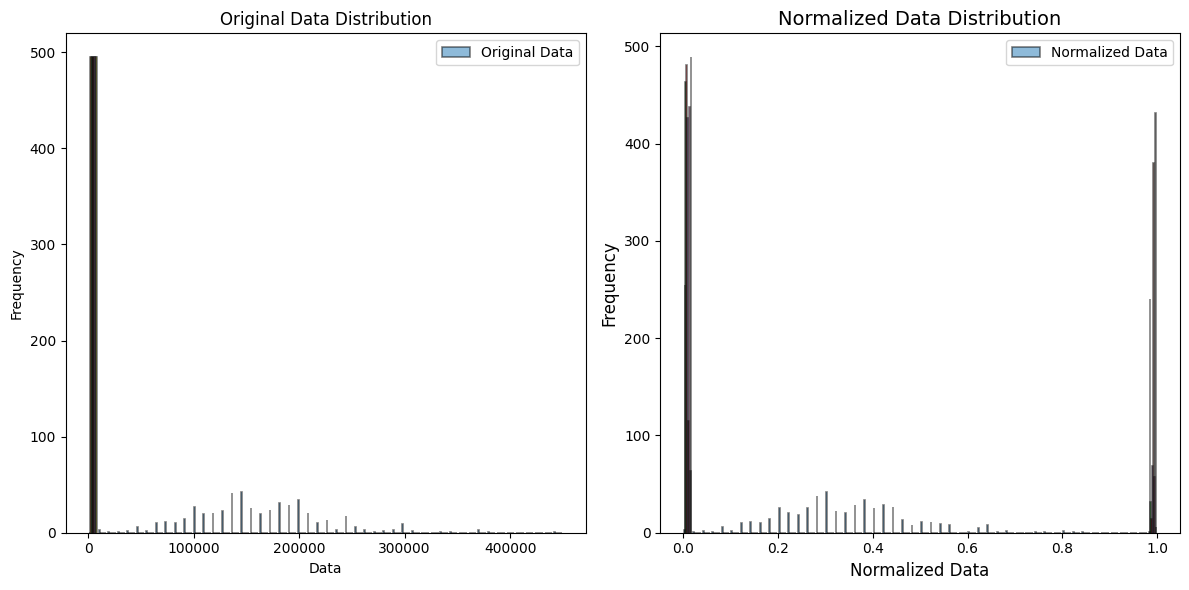

In [29]:
# Create histograms for both original and normalized data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(data, bins=50, alpha=0.5, label='Original Data', edgecolor='black', linewidth=1.2)
plt.title('Original Data Distribution')
plt.xlabel('Data')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(data_norm, bins=50, alpha=0.5, label='Normalized Data', edgecolor='black', linewidth=1.2)
plt.title('Normalized Data Distribution', fontsize=14)
plt.xlabel('Normalized Data', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
# Convert back to DataFrame and add job_title column
data_norm = np.column_stack((data_norm, job_title))
data_norm = pd.DataFrame(data_norm, columns=data.columns.tolist() + ['job_title'])

data_norm.head()

,salary,remote_ratio,EN,EX,MI,SE,L,M,S,job_title
0,0.534091,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Analytics Engineer
1,0.325,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Analytics Engineer
2,0.292614,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Analytics Engineer
3,0.385955,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Analytics Engineer
4,0.334091,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Analytics Engineer


It seems that the normalization of the data did not yield a considerable shift in the distribution of the existing data. This will not be as helpful as the standardization of the data.

I think that the most useful graphs that were generated were the box plot, the stacked bar graphs and the facet grid. Each of these graphs directly contributed to understanding how the features relate to the job titles and thus how they could be used to help predict job titles. The box plot shows the salary difference by job title. The stacked bar graphs show the distribution of experience level, company size, and remote obligation by job title, respectively. The facet grid provided a better ability to differentiate job titles by salary distribution than did the box plot alone.

I will now use my standardized data to create KNN, logistic regression, Random Forest, and MLPC to attempt to predict the job title of an employee based on the other features and to assess the accuracies of each model:

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('job_title', axis=1), data_scaled['job_title'], test_size=0.2, random_state=42)

In [32]:
# Implement K-NN model
from sklearn.neighbors import KNeighborsClassifier
for neighbors in [1, 3, 9, 21]:
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    knn.fit(X_train, y_train)
    print("%s-NN" %(neighbors), "Training Accuracy: ", knn.score(X_train, y_train))
    print("%s-NN" %(neighbors), "Test Accuracy: ", knn.score(X_test, y_test))
    print()

1-NN Training Accuracy:  0.8585858585858586
1-NN Test Accuracy:  0.29292929292929293

3-NN Training Accuracy:  0.5707070707070707
3-NN Test Accuracy:  0.25252525252525254

9-NN Training Accuracy:  0.4292929292929293
9-NN Test Accuracy:  0.26262626262626265

21-NN Training Accuracy:  0.31313131313131315
21-NN Test Accuracy:  0.2727272727272727



It seems that the KNN model is not very accurate. 3-NN demonstrated the best accuracy which was 44.7%.

In [33]:
# Implement Logistic Regression model
from sklearn.linear_model import LogisticRegression
# Cross Validation
for c in [0.01, 0.1, 1, 10, 100]:
  for iter in [1000, 3000, 5000]:
    total_train_accuracy = 0
    max_train_accuracy = 0
    min_train_accuracy = 1
    total_test_accuracy = 0
    max_test_accuracy = 0
    min_test_accuracy = 1
    best_param = [0]
    for val in range(10):
      X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('job_title', axis=1), data_scaled['job_title'], test_size=0.2, random_state=val * 42)
      logreg = LogisticRegression(C=c, max_iter=iter)
      logreg.fit(X_train, y_train)
      
      # Train Data
      total_train_accuracy += logreg.score(X_train, y_train)
      if logreg.score(X_train, y_train) > max_train_accuracy:
        max_train_accuracy = logreg.score(X_train, y_train)
      if logreg.score(X_train, y_train) < min_train_accuracy:
        min_train_accuracy = logreg.score(X_train, y_train)
      
      #Test Data
      total_test_accuracy += logreg.score(X_test, y_test)
      if logreg.score(X_test, y_test) > max_test_accuracy:
        max_test_accuracy = logreg.score(X_test, y_test)
      if logreg.score(X_test, y_test) < min_test_accuracy:
        min_test_accuracy = logreg.score(X_test, y_test)
    
    print("C: %f Max_Iter: %f" %(c, iter))
    print("Train:")
    print("Avg: %f" %(total_train_accuracy / 10))
    print("Max: %f" %(max_train_accuracy))
    print("Min: %f" %(min_train_accuracy))
    print("Test:")
    print("Avg: %f" %(total_test_accuracy / 10))
    print("Max: %f" %(max_test_accuracy))
    print("Min: %f" %(min_test_accuracy))
    print()
    best_param = [total_test_accuracy / 10] if total_test_accuracy / 10 > best_param[0] else best_param
print(best_param)

C: 0.010000 Max_Iter: 1000.000000
Train:
Avg: 0.270202
Max: 0.287879
Min: 0.250000
Test:
Avg: 0.209091
Max: 0.272727
Min: 0.111111

C: 0.010000 Max_Iter: 3000.000000
Train:
Avg: 0.270202
Max: 0.287879
Min: 0.250000
Test:
Avg: 0.209091
Max: 0.272727
Min: 0.111111

C: 0.010000 Max_Iter: 5000.000000
Train:
Avg: 0.270202
Max: 0.287879
Min: 0.250000
Test:
Avg: 0.209091
Max: 0.272727
Min: 0.111111

C: 0.100000 Max_Iter: 1000.000000
Train:
Avg: 0.292172
Max: 0.315657
Min: 0.267677
Test:
Avg: 0.244444
Max: 0.323232
Min: 0.151515

C: 0.100000 Max_Iter: 3000.000000
Train:
Avg: 0.292172
Max: 0.315657
Min: 0.267677
Test:
Avg: 0.244444
Max: 0.323232
Min: 0.151515

C: 0.100000 Max_Iter: 5000.000000
Train:
Avg: 0.292172
Max: 0.315657
Min: 0.267677
Test:
Avg: 0.244444
Max: 0.323232
Min: 0.151515

C: 1.000000 Max_Iter: 1000.000000
Train:
Avg: 0.294697
Max: 0.323232
Min: 0.262626
Test:
Avg: 0.242424
Max: 0.323232
Min: 0.171717

C: 1.000000 Max_Iter: 3000.000000
Train:
Avg: 0.294697
Max: 0.323232
Min: 0.

It seems that the Logistic Regression actually performed worse than the KNN model with a best average test accuracy of 23.9%.

In [34]:
# Implement LinearSVC model
from sklearn.svm import LinearSVC
for c in [0.01, 0.1, 1, 10, 100]:
  for iter in [1000, 3000, 5000]:
    total_train_accuracy = 0
    max_train_accuracy = 0
    min_train_accuracy = 1
    total_test_accuracy = 0
    max_test_accuracy = 0
    min_test_accuracy = 1
    best_par = [0]
    for val in range(10):
      X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('job_title', axis=1), data_scaled['job_title'], test_size=0.2, random_state=val * 42)
      svc = LinearSVC(C=c, max_iter=iter)
      svc.fit(X_train, y_train)

      # Train Data
      total_train_accuracy += svc.score(X_train, y_train)
      if svc.score(X_train, y_train) > max_train_accuracy:
        max_train_accuracy = svc.score(X_train, y_train)
      if svc.score(X_train, y_train) < min_train_accuracy:
        min_train_accuracy = svc.score(X_train, y_train)
      
      #Test Data
      total_test_accuracy += svc.score(X_test, y_test)
      if svc.score(X_test, y_test) > max_test_accuracy:
        max_test_accuracy = svc.score(X_test, y_test)
      if svc.score(X_test, y_test) < min_test_accuracy:
        min_test_accuracy = svc.score(X_test, y_test)
      
    print("C: %f Max_Iter: %f" %(c, iter))
    print("Train:")
    print("Avg: %f" %(total_train_accuracy / 10))
    print("Max: %f" %(max_train_accuracy))
    print("Min: %f" %(min_train_accuracy))
    print("Test:")
    print("Avg: %f" %(total_test_accuracy / 10))
    print("Max: %f" %(max_test_accuracy))
    print("Min: %f" %(min_test_accuracy))
    print()
    best_par = [total_test_accuracy / 10] if total_test_accuracy / 10 > best_par[0] else best_par
print(best_par)

C: 0.010000 Max_Iter: 1000.000000
Train:
Avg: 0.284091
Max: 0.303030
Min: 0.265152
Test:
Avg: 0.228283
Max: 0.313131
Min: 0.151515

C: 0.010000 Max_Iter: 3000.000000
Train:
Avg: 0.284091
Max: 0.303030
Min: 0.265152
Test:
Avg: 0.228283
Max: 0.313131
Min: 0.151515

C: 0.010000 Max_Iter: 5000.000000
Train:
Avg: 0.284091
Max: 0.303030
Min: 0.265152
Test:
Avg: 0.228283
Max: 0.313131
Min: 0.151515

C: 0.100000 Max_Iter: 1000.000000
Train:
Avg: 0.290909
Max: 0.313131
Min: 0.270202
Test:
Avg: 0.237374
Max: 0.323232
Min: 0.141414

C: 0.100000 Max_Iter: 3000.000000
Train:
Avg: 0.290909
Max: 0.313131
Min: 0.270202
Test:
Avg: 0.237374
Max: 0.323232
Min: 0.141414

C: 0.100000 Max_Iter: 5000.000000
Train:
Avg: 0.290909
Max: 0.313131
Min: 0.270202
Test:
Avg: 0.237374
Max: 0.323232
Min: 0.141414

C: 1.000000 Max_Iter: 1000.000000
Train:
Avg: 0.292172
Max: 0.310606
Min: 0.272727
Test:
Avg: 0.237374
Max: 0.323232
Min: 0.151515

C: 1.000000 Max_Iter: 3000.000000
Train:
Avg: 0.292677
Max: 0.313131
Min: 0.

LinearSVC yielded a 23.8% accuracy which is on par with what has been seen so far.

In [61]:
# Implement Random Forest model
from sklearn.ensemble import RandomForestClassifier
total_train_accuracy = 0
max_train_accuracy = 0
min_train_accuracy = 1
total_test_accuracy = 0
max_test_accuracy = 0
min_test_accuracy = 1
best = [0]
for nest in [10000]:
    
    X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('job_title', axis=1), data_scaled['job_title'], test_size=0.2, random_state=42)
    rf = RandomForestClassifier(n_estimators=nest, random_state=42)
    rf.fit(X_train, y_train)
    # Train Data
    total_train_accuracy += rf.score(X_train, y_train)
    if rf.score(X_train, y_train) > max_train_accuracy:
        max_train_accuracy = rf.score(X_train, y_train)
    if rf.score(X_train, y_train) < min_train_accuracy:
        min_train_accuracy = rf.score(X_train, y_train)
    
    #Test Data
    total_test_accuracy += rf.score(X_test, y_test)
    if rf.score(X_test, y_test) > max_test_accuracy:
        max_test_accuracy = rf.score(X_test, y_test)
    if rf.score(X_test, y_test) < min_test_accuracy:
        min_test_accuracy = rf.score(X_test, y_test)
        
    print("Estimators: %d" %(nest))
    print("Train:")
    print("Max: %f" %(max_train_accuracy))
    print("Min: %f" %(min_train_accuracy))
    print("Test:")
    print("Max: %f" %(max_test_accuracy))
    print("Min: %f" %(min_test_accuracy))
    print()

Estimators: 10000
Train:
Max: 0.873737
Min: 0.873737
Test:
Max: 0.313131
Min: 0.313131



Though the Random Forest did better than KNN and Logistic Regression and is a step in the right direction, it is still not very accurate. 50 estimators yielded the best accuracy of 39.7%. 

In [62]:
import time

# Implement the MLPC model
from sklearn.neural_network import MLPClassifier

# Cross Validation


# Train MLPClassifier models with different settings
best_params = [0, 0, 0]
for n_hidden_nodes in [10, 100, 200, 300, 400]:
    for alpha in [0.0001, 0.001, 0.01, 0.1, 1]:
        total_train_accuracy = 0
        max_train_accuracy = 0
        min_train_accuracy = 1
        total_test_accuracy = 0
        max_test_accuracy = 0
        min_test_accuracy = 1
        for val in range(10):
            X_train, X_test, y_train, y_test = train_test_split(data_scaled.drop('job_title', axis=1), data_scaled['job_title'], test_size=0.2, random_state=val * 42)
            mlpc = MLPClassifier(solver='lbfgs', random_state=round(time.time() / 1000), hidden_layer_sizes=[n_hidden_nodes, n_hidden_nodes], alpha=alpha)
            mlpc.fit(X_train, y_train)
            total_train_accuracy += mlpc.score(X_train, y_train)
            if mlpc.score(X_train, y_train) > max_train_accuracy:
                max_train_accuracy = mlpc.score(X_train, y_train)
            if mlpc.score(X_train, y_train) < min_train_accuracy:
                min_train_accuracy = mlpc.score(X_train, y_train)
            total_test_accuracy += mlpc.score(X_test, y_test)
            if mlpc.score(X_test, y_test) > max_test_accuracy:
                max_test_accuracy = mlpc.score(X_test, y_test)
            if mlpc.score(X_test, y_test) < min_test_accuracy:
                min_test_accuracy = mlpc.score(X_test, y_test)
        
        print("Hidden Nodes: [%d, %d] Alpha: %f" %(n_hidden_nodes, n_hidden_nodes, alpha))
        print("Train:")
        print("Avg: %f" %(total_train_accuracy / 10))
        print("Max: %f" %(max_train_accuracy))
        print("Min: %f" %(min_train_accuracy))
        print("Test:")
        print("Avg: %f" %(total_test_accuracy / 10))
        print("Max: %f" %(max_test_accuracy))
        print("Min: %f" %(min_test_accuracy))
        print()
        best_params = [n_hidden_nodes, alpha, total_test_accuracy / 10] if total_test_accuracy / 10 > best_params[2] else best_params


print(best_params)


Hidden Nodes: [10, 10] Alpha: 0.000100
Train:
Avg: 0.392677
Max: 0.414141
Min: 0.371212
Test:
Avg: 0.242424
Max: 0.323232
Min: 0.131313

Hidden Nodes: [10, 10] Alpha: 0.001000
Train:
Avg: 0.389646
Max: 0.411616
Min: 0.371212
Test:
Avg: 0.242424
Max: 0.323232
Min: 0.141414

Hidden Nodes: [10, 10] Alpha: 0.010000
Train:
Avg: 0.386111
Max: 0.401515
Min: 0.366162
Test:
Avg: 0.246465
Max: 0.282828
Min: 0.191919

Hidden Nodes: [10, 10] Alpha: 0.100000
Train:
Avg: 0.380051
Max: 0.398990
Min: 0.363636
Test:
Avg: 0.254545
Max: 0.303030
Min: 0.222222

Hidden Nodes: [10, 10] Alpha: 1.000000
Train:
Avg: 0.383081
Max: 0.406566
Min: 0.363636
Test:
Avg: 0.249495
Max: 0.343434
Min: 0.202020

Hidden Nodes: [100, 100] Alpha: 0.000100
Train:
Avg: 0.553788
Max: 0.583333
Min: 0.522727
Test:
Avg: 0.271717
Max: 0.323232
Min: 0.212121

Hidden Nodes: [100, 100] Alpha: 0.001000
Train:
Avg: 0.556566
Max: 0.590909
Min: 0.520202
Test:
Avg: 0.281818
Max: 0.343434
Min: 0.222222

Hidden Nodes: [100, 100] Alpha: 0.010

The MLPC model shows its best work to be at just under 30%.
The parameters I used were the 'lbgfs' solver, two hidden layers of 400 nodes and alphas of .01

After using many different algorithms, I was able to achieve approximately 30% accuracy in classifying the job title of an employee based on the other features. 

Although this does not seem very accurate at first glance, let us consider what accuracy we would get if we just chose randomly.
If we were to just assign job titles randomly, since there are 9 different job titles to choose from:

1/9 ~= 11% accuracy.

Thus using machine learning, I was able to increase our ability to predict job title by ~= 20% accuracy, 3X!
Thus machine learning did help us to move closer to a solution with this dataset.

This assignment helped me to apply a lot of the models that we have learned about in class to a real example. I found it very helpful to be able to apply the models to a real world example. I also found it very helpful to be able to see how the different models performed on the data and how they compared to each other.